In [28]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [30]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [31]:
sensor_columns = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W',
                  'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
                  'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']

def compute_features(df):
    features = df.groupby('series_id')[sensor_columns].agg(['mean', 'std', 'min', 'max'])
    features.columns = ['_'.join(col).strip() for col in features.columns.values]
    return features

# Compute features for X_train
X_features = compute_features(X_train)
X_features.reset_index(inplace=True)
X_features.head()


,series_id,orientation_X_mean,orientation_X_std,orientation_X_min,orientation_X_max,orientation_Y_mean,orientation_Y_std,orientation_Y_min,orientation_Y_max,orientation_Z_mean,...,linear_acceleration_X_min,linear_acceleration_X_max,linear_acceleration_Y_mean,linear_acceleration_Y_std,linear_acceleration_Y_min,linear_acceleration_Y_max,linear_acceleration_Z_mean,linear_acceleration_Z_std,linear_acceleration_Z_min,linear_acceleration_Z_max
0,0,-0.758666,0.000363,-0.75953,-0.75822,-0.634008,0.000471,-0.63456,-0.63306,-0.105474,...,-1.8644,2.85380,2.984195,1.387790,0.075417,5.3864,-9.320391,1.095040,-12.512,-6.2681
1,1,-0.958606,0.000151,-0.95896,-0.95837,0.241867,0.000499,0.24074,0.24270,0.031650,...,-3.1934,5.10020,2.768193,1.864457,-2.149200,6.6850,-9.388899,2.123065,-16.928,-2.7449
2,2,-0.512057,0.001377,-0.51434,-0.50944,-0.846171,0.000785,-0.84779,-0.84490,-0.129371,...,-2.5930,1.85330,2.886745,1.769792,-1.254000,6.2105,-9.395783,1.140267,-12.499,-5.7442
3,3,-0.939169,0.000227,-0.93968,-0.93884,0.310140,0.000453,0.30943,0.31147,0.038955,...,-3.7934,4.20320,2.657922,4.201410,-5.825100,11.7430,-9.451164,3.478530,-19.845,-0.5591
4,4,-0.891301,0.002955,-0.89689,-0.88673,0.428144,0.006165,0.41646,0.43740,0.060056,...,-1.2696,0.82891,2.981498,1.137776,0.342070,4.8181,-9.349988,0.812585,-10.975,-7.4490


In [32]:
# Merge with labels
data = X_features.merge(y_train, on='series_id', how='left')
data.head()

,series_id,orientation_X_mean,orientation_X_std,orientation_X_min,orientation_X_max,orientation_Y_mean,orientation_Y_std,orientation_Y_min,orientation_Y_max,orientation_Z_mean,...,linear_acceleration_Y_mean,linear_acceleration_Y_std,linear_acceleration_Y_min,linear_acceleration_Y_max,linear_acceleration_Z_mean,linear_acceleration_Z_std,linear_acceleration_Z_min,linear_acceleration_Z_max,group_id,surface
0,0,-0.758666,0.000363,-0.75953,-0.75822,-0.634008,0.000471,-0.63456,-0.63306,-0.105474,...,2.984195,1.387790,0.075417,5.3864,-9.320391,1.095040,-12.512,-6.2681,13,fine_concrete
1,1,-0.958606,0.000151,-0.95896,-0.95837,0.241867,0.000499,0.24074,0.24270,0.031650,...,2.768193,1.864457,-2.149200,6.6850,-9.388899,2.123065,-16.928,-2.7449,31,concrete
2,2,-0.512057,0.001377,-0.51434,-0.50944,-0.846171,0.000785,-0.84779,-0.84490,-0.129371,...,2.886745,1.769792,-1.254000,6.2105,-9.395783,1.140267,-12.499,-5.7442,20,concrete
3,3,-0.939169,0.000227,-0.93968,-0.93884,0.310140,0.000453,0.30943,0.31147,0.038955,...,2.657922,4.201410,-5.825100,11.7430,-9.451164,3.478530,-19.845,-0.5591,31,concrete
4,4,-0.891301,0.002955,-0.89689,-0.88673,0.428144,0.006165,0.41646,0.43740,0.060056,...,2.981498,1.137776,0.342070,4.8181,-9.349988,0.812585,-10.975,-7.4490,22,soft_tiles


In [33]:
# Encode the 'surface' column
surface_labels = data['surface'].unique()
surface_to_int = {label: idx for idx, label in enumerate(surface_labels)}
data['surface_encoded'] = data['surface'].map(surface_to_int)
data.head()

,series_id,orientation_X_mean,orientation_X_std,orientation_X_min,orientation_X_max,orientation_Y_mean,orientation_Y_std,orientation_Y_min,orientation_Y_max,orientation_Z_mean,...,linear_acceleration_Y_std,linear_acceleration_Y_min,linear_acceleration_Y_max,linear_acceleration_Z_mean,linear_acceleration_Z_std,linear_acceleration_Z_min,linear_acceleration_Z_max,group_id,surface,surface_encoded
0,0,-0.758666,0.000363,-0.75953,-0.75822,-0.634008,0.000471,-0.63456,-0.63306,-0.105474,...,1.387790,0.075417,5.3864,-9.320391,1.095040,-12.512,-6.2681,13,fine_concrete,0
1,1,-0.958606,0.000151,-0.95896,-0.95837,0.241867,0.000499,0.24074,0.24270,0.031650,...,1.864457,-2.149200,6.6850,-9.388899,2.123065,-16.928,-2.7449,31,concrete,1
2,2,-0.512057,0.001377,-0.51434,-0.50944,-0.846171,0.000785,-0.84779,-0.84490,-0.129371,...,1.769792,-1.254000,6.2105,-9.395783,1.140267,-12.499,-5.7442,20,concrete,1
3,3,-0.939169,0.000227,-0.93968,-0.93884,0.310140,0.000453,0.30943,0.31147,0.038955,...,4.201410,-5.825100,11.7430,-9.451164,3.478530,-19.845,-0.5591,31,concrete,1
4,4,-0.891301,0.002955,-0.89689,-0.88673,0.428144,0.006165,0.41646,0.43740,0.060056,...,1.137776,0.342070,4.8181,-9.349988,0.812585,-10.975,-7.4490,22,soft_tiles,2


In [34]:
# Prepare feature matrix X and target vector y
X = data.drop(['series_id', 'group_id', 'surface', 'surface_encoded'], axis=1).values
y = data['surface_encoded'].values

# Split into training and validation sets
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)
split_ratio = 0.8
split_point = int(split_ratio * len(X))
train_indices = indices[:split_point]
val_indices = indices[split_point:]

X_train_data = X[train_indices]
y_train_data = y[train_indices]

X_val_data = X[val_indices]
y_val_data = y[val_indices]

In [35]:
def gini_impurity(labels):
    classes, counts = np.unique(labels, return_counts=True)
    impurity = 1.0
    total = len(labels)
    for count in counts:
        prob = count / total
        impurity -= prob ** 2
    return impurity

def compute_split_impurity(labels_list):
    total_count = sum(len(labels) for labels in labels_list)
    impurity = 0.0
    for labels in labels_list:
        impurity += (len(labels) / total_count) * gini_impurity(labels)
    return impurity

In [36]:
class Node:
    def __init__(self, depth=0, max_depth=None):
        self.depth = depth
        self.max_depth = max_depth
        self.feature_index = None
        self.thresholds = None
        self.children = []
        self.is_leaf = False
        self.class_label = None
        self.class_counts = None

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None
        
    def fit(self, X, y, feature_bins):
        self.root = self._build_tree(X, y, feature_bins, depth=0)
        
    def _build_tree(self, X, y, feature_bins, depth):
        node = Node(depth=depth, max_depth=self.max_depth)
        # Check for stopping conditions
        if len(np.unique(y)) == 1:
            node.is_leaf = True
            node.class_label = y[0]
            node.class_counts = {y[0]: len(y)}
            return node
        if self.max_depth is not None and depth >= self.max_depth:
            node.is_leaf = True
            node.class_label = self._majority_class(y)
            classes, counts = np.unique(y, return_counts=True)
            node.class_counts = dict(zip(classes, counts))
            return node
        # Find the best split
        best_feature, best_thresholds, best_impurity, best_splits = self._find_best_split(X, y, feature_bins)
        if best_feature is None:
            node.is_leaf = True
            node.class_label = self._majority_class(y)
            classes, counts = np.unique(y, return_counts=True)
            node.class_counts = dict(zip(classes, counts))
            return node
        node.feature_index = best_feature
        node.thresholds = best_thresholds
        # Create child nodes
        for split_X, split_y in best_splits:
            if len(split_y) == 0:
                # Create a leaf node with the majority class of the parent node
                child_node = Node(depth=depth + 1, max_depth=self.max_depth)
                child_node.is_leaf = True
                child_node.class_label = self._majority_class(y)
                classes, counts = np.unique(y, return_counts=True)
                child_node.class_counts = dict(zip(classes, counts))
            else:
                child_node = self._build_tree(split_X, split_y, feature_bins, depth+1)
            node.children.append(child_node)
        return node
    
    def _majority_class(self, y):
        classes, counts = np.unique(y, return_counts=True)
        return classes[np.argmax(counts)]
    
    def _find_best_split(self, X, y, feature_bins):
        best_impurity = np.inf
        best_feature = None
        best_thresholds = None
        best_splits = None
        n_features = X.shape[1]
        for feature_index in range(n_features):
            bins = feature_bins[feature_index]
            # Split data into bins
            indices = []
            for i in range(len(bins) + 1):
                if i == 0:
                    idx = np.where(X[:, feature_index] <= bins[i])[0]
                elif i == len(bins):
                    idx = np.where(X[:, feature_index] > bins[i-1])[0]
                else:
                    idx = np.where((X[:, feature_index] > bins[i-1]) & (X[:, feature_index] <= bins[i]))[0]
                # Include empty splits
                indices.append(idx)
            splits_X = [X[idx] for idx in indices]
            splits_y = [y[idx] for idx in indices]
            impurity = compute_split_impurity(splits_y)
            if impurity < best_impurity:
                best_impurity = impurity
                best_feature = feature_index
                best_thresholds = bins
                best_splits = list(zip(splits_X, splits_y))
        return best_feature, best_thresholds, best_impurity, best_splits
    
    def predict(self, X):
        predictions = [self._predict_row(x, self.root) for x in X]
        return np.array(predictions)
    
    def _predict_row(self, x, node):
        if node.is_leaf:
            return node.class_label
        # Determine which child to go to
        feature_value = x[node.feature_index]
        thresholds = node.thresholds
        for i in range(len(thresholds) + 1):
            if i == 0:
                if feature_value <= thresholds[i]:
                    return self._predict_row(x, node.children[i])
            elif i == len(thresholds):
                if feature_value > thresholds[i-1]:
                    return self._predict_row(x, node.children[i])
            else:
                if thresholds[i-1] < feature_value <= thresholds[i]:
                    return self._predict_row(x, node.children[i])
        # If none of the conditions match, return the majority class of the current node
        return node.class_label


In [37]:
# Compute feature bins
feature_bins = {}
for i in range(X_train_data.shape[1]):
    feature = X_train_data[:, i]
    bins = np.quantile(feature, [0.25, 0.5, 0.75])
    feature_bins[i] = bins


In [38]:
# Train the decision tree
tree = DecisionTree(max_depth=5)
tree.fit(X_train_data, y_train_data, feature_bins)

In [39]:
y_pred = tree.predict(X_val_data)

In [40]:
accuracy = np.mean(y_pred == y_val_data)
print("Accuracy:", accuracy)

Accuracy: 0.6391076115485564


In [41]:
# List of classes
classes = np.unique(y_train_data)

def compute_precision_recall_f1(y_true, y_pred, classes):
    precisions = []
    recalls = []
    f1_scores = []
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        if tp + fp == 0:
            precision = 0.0
        else:
            precision = tp / (tp + fp)
        if tp + fn == 0:
            recall = 0.0
        else:
            recall = tp / (tp + fn)
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * precision * recall / (precision + recall)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    return precisions, recalls, f1_scores

precisions, recalls, f1_scores = compute_precision_recall_f1(y_val_data, y_pred, classes)

for i, cls in enumerate(classes):
    print(f"Class {cls}: Precision={precisions[i]:.3f}, Recall={recalls[i]:.3f}, F1-score={f1_scores[i]:.3f}")

macro_precision = np.mean(precisions)
macro_recall = np.mean(recalls)
macro_f1 = np.mean(f1_scores)
print(f"\nMacro-averaged Precision: {macro_precision:.3f}")
print(f"Macro-averaged Recall: {macro_recall:.3f}")
print(f"Macro-averaged F1-score: {macro_f1:.3f}")

Class 0: Precision=0.462, Recall=0.411, F1-score=0.435
Class 1: Precision=0.639, Recall=0.697, F1-score=0.667
Class 2: Precision=0.661, Recall=0.684, F1-score=0.672
Class 3: Precision=0.608, Recall=0.693, F1-score=0.648
Class 4: Precision=0.714, Recall=0.737, F1-score=0.726
Class 5: Precision=0.804, Recall=0.683, F1-score=0.739
Class 6: Precision=0.500, Recall=0.286, F1-score=0.364
Class 7: Precision=0.000, Recall=0.000, F1-score=0.000
Class 8: Precision=0.626, Recall=0.605, F1-score=0.615

Macro-averaged Precision: 0.557
Macro-averaged Recall: 0.533
Macro-averaged F1-score: 0.541


In [42]:
# Add predict_proba method to DecisionTree class
def predict_proba(self, X):
    probabilities = [self._predict_row_proba(x, self.root) for x in X]
    return probabilities

def _predict_row_proba(self, x, node):
    if node.is_leaf:
        total = sum(node.class_counts.values())
        probs = {cls: node.class_counts.get(cls, 0) / total for cls in classes}
        return probs
    # Determine which child to go to
    feature_value = x[node.feature_index]
    thresholds = node.thresholds
    for i in range(len(thresholds) + 1):
        if i == 0:
            if feature_value <= thresholds[i]:
                return self._predict_row_proba(x, node.children[i])
        elif i == len(thresholds):
            if feature_value > thresholds[i-1]:
                return self._predict_row_proba(x, node.children[i])
        else:
            if thresholds[i-1] < feature_value <= thresholds[i]:
                return self._predict_row_proba(x, node.children[i])
    return None

DecisionTree.predict_proba = predict_proba
DecisionTree._predict_row_proba = _predict_row_proba

In [43]:
probs = tree.predict_proba(X_val_data)

In [44]:
def compute_roc_curve(y_true, y_score):
    thresholds = np.unique(y_score)
    thresholds = np.sort(np.append(thresholds, [0.0, 1.0]))
    tprs = []
    fprs = []
    for thresh in thresholds:
        y_pred = (y_score >= thresh).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        tprs.append(tpr)
        fprs.append(fpr)
    return fprs, tprs


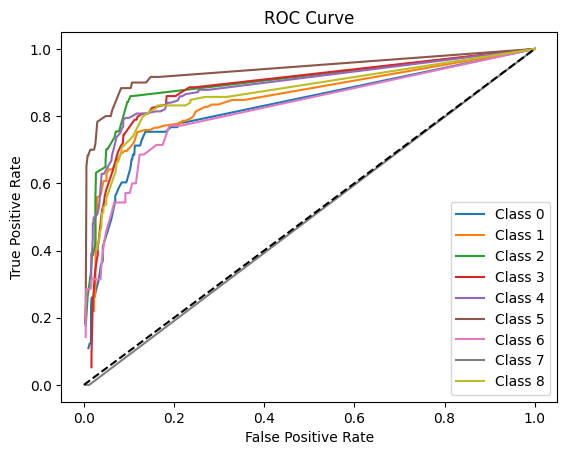

In [45]:
for cls in classes:
    y_true_cls = (y_val_data == cls).astype(int)
    y_score_cls = np.array([probs[i].get(cls, 0.0) for i in range(len(probs))])
    fprs, tprs = compute_roc_curve(y_true_cls, y_score_cls)
    plt.plot(fprs, tprs, label=f'Class {cls}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [46]:
class RandomForest:
    def __init__(self, n_estimators=10, max_depth=None, max_features='sqrt'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        self.feature_indices = []
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        for _ in range(self.n_estimators):
            # Sample data with replacement
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            # Select features
            if self.max_features == 'sqrt':
                n_sub_features = int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                n_sub_features = int(np.log2(n_features))
            else:
                n_sub_features = n_features
            feature_indices = np.random.choice(n_features, n_sub_features, replace=False)
            self.feature_indices.append(feature_indices)
            # Subset the data to selected features
            X_sample_features = X_sample[:, feature_indices]
            # Create feature bins for selected features
            feature_bins = {}
            for idx_in_tree in range(n_sub_features):
                feature = X_sample_features[:, idx_in_tree]
                bins = np.quantile(feature, [0.25, 0.5, 0.75])
                feature_bins[idx_in_tree] = bins
            # Train tree
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_sample_features, y_sample, feature_bins)
            self.trees.append((tree, feature_indices))

        
    def predict(self, X):
        tree_predictions = []
        for tree, feature_indices in self.trees:
            preds = tree.predict(X[:, feature_indices])
            tree_predictions.append(preds)
        # Majority vote
        tree_predictions = np.array(tree_predictions)
        final_predictions = []
        for i in range(X.shape[0]):
            preds = tree_predictions[:, i]
            classes_, counts = np.unique(preds, return_counts=True)
            final_predictions.append(classes_[np.argmax(counts)])
        return np.array(final_predictions)




In [47]:
rf = RandomForest(n_estimators=10, max_depth=5)
rf.fit(X_train_data, y_train_data)


In [48]:
y_pred_rf = rf.predict(X_val_data)

In [49]:
accuracy_rf = np.mean(y_pred_rf == y_val_data)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.6496062992125984


In [50]:
precisions_rf, recalls_rf, f1_scores_rf = compute_precision_recall_f1(y_val_data, y_pred_rf, classes)

for i, cls in enumerate(classes):
    print(f"Class {cls}: Precision={precisions_rf[i]:.3f}, Recall={recalls_rf[i]:.3f}, F1-score={f1_scores_rf[i]:.3f}")

macro_precision_rf = np.mean(precisions_rf)
macro_recall_rf = np.mean(recalls_rf)
macro_f1_rf = np.mean(f1_scores_rf)
print(f"\nMacro-averaged Precision: {macro_precision_rf:.3f}")
print(f"Macro-averaged Recall: {macro_recall_rf:.3f}")
print(f"Macro-averaged F1-score: {macro_f1_rf:.3f}")

Class 0: Precision=0.483, Recall=0.397, F1-score=0.436
Class 1: Precision=0.592, Recall=0.752, F1-score=0.663
Class 2: Precision=0.562, Recall=0.877, F1-score=0.685
Class 3: Precision=0.672, Recall=0.684, F1-score=0.678
Class 4: Precision=0.765, Recall=0.795, F1-score=0.780
Class 5: Precision=0.723, Recall=0.567, F1-score=0.636
Class 6: Precision=0.333, Recall=0.114, F1-score=0.170
Class 7: Precision=1.000, Recall=0.333, F1-score=0.500
Class 8: Precision=0.725, Recall=0.555, F1-score=0.629

Macro-averaged Precision: 0.651
Macro-averaged Recall: 0.564
Macro-averaged F1-score: 0.575


In [51]:
def predict_proba(self, X):
    tree_probabilities = []
    for tree, feature_indices in self.trees:
        probs = tree.predict_proba(X[:, feature_indices])
        tree_probabilities.append(probs)
    # Average the probabilities
    final_probabilities = []
    for i in range(X.shape[0]):
        avg_probs = {}
        for cls in classes:
            avg_probs[cls] = np.mean([tree_probabilities[j][i].get(cls, 0.0) for j in range(len(self.trees))])
        final_probabilities.append(avg_probs)
    return final_probabilities

RandomForest.predict_proba = predict_proba

In [52]:
probs_rf = rf.predict_proba(X_val_data)

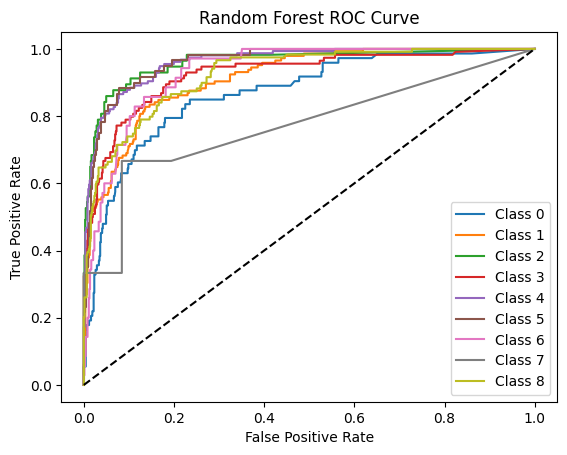

In [53]:
for cls in classes:
    y_true_cls = (y_val_data == cls).astype(int)
    y_score_cls = np.array([probs_rf[i].get(cls, 0.0) for i in range(len(probs_rf))])
    fprs, tprs = compute_roc_curve(y_true_cls, y_score_cls)
    plt.plot(fprs, tprs, label=f'Class {cls}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.show()